#  Early RPC cells Subclutering

This Python notebook performs an analysis of the cell types and their marker genes on provided 10X dataset. Specifically, we'll focus on subclustering Early RPC cells. The data set contains ~107,000 cells of which approximately a half come from E14, E18, and P2. 

## Table of contents:

  * <a href=#Reading>1 Reading in the data</a>
  * <a href=#Preprocessing>2 Pre-processing and visualization</a>
    * <a href=#QC>2.1 Quality Control</a>
    * <a href=#Normalization>2.2 Normalization</a> 
    * <a href=#Batch>2.3 Batch correction</a>
    * <a href=#HVG>2.4 Highly variable genes</a>
    * <a href=#Visualization>2.5 Visualization</a>
    * <a href=#CC>2.6 Cell cycle scoring</a>
  * <a href=#Downstream>3 Downstream analysis</a>
    * <a href=#Clustering>3.1 Clustering</a>
    * <a href=#Markers>3.2 Marker genes & cluster annotation</a>
    * <a href=#Subclustering>3.3 Subclustering</a>
  * <a href=#Summary>4 Summary</a>


# 0. Loading the libraries

In [1]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sns



In [2]:
sc.settings.verbosity = 3            
sc.settings.set_figure_params(dpi=80, facecolor='white')
plt.rcParams['figure.figsize']=(8,8) #rescale figures

# 1. Reading in the data

The count matrix is provided in .mtx format and can be downloaded here: [10x_mouse_retina_development.mtx](https://www.dropbox.com/s/6d76z4grcnaxgcg/10x_mouse_retina_development.mtx?dl=0)

- matrix.mtx - The count matrix containing raw counts for barcodes. Rows correspond to cells and columns to genes
- genes.tsv - contains the ensembl IDs labelling the genes in each column of the counts matrix
- barcodes.tsv - contains the cell barcodes labelling the cells in each row of the counts matrix
- 10x_Mouse_retina_pData_umap2_CellType_annot_w_horiz.csv - Cellular Phenotype Data


Finally, the `Macosko_cell_cycle_genes.txt` contains a list of marker genes for different cell cycle phases. We'd use this file in the <a href=#CC>Cell cycle scoring</a> section to compute cell cycle scores, but will not particularly regress out cell cycle effects.


In [3]:
results_file = 'swrite/retsmart.h5ad'  # the file that will store the analysis results


adata = sc.read_10x_mtx(
    'sdata',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading


genes= pd.read_csv('sdata/GSE118614_Smart_genes.tsv', header=0, sep='\t')


cells = pd.read_csv('sdata/GSE118614_Smart_cells.tsv', header=0, sep='\t')
adata.obs['CellType']=cells['CellType'].values
adata.obs['Age']=cells['Age'].values
adata.obs['Plate']=cells['Plate'].values



... reading from cache file cache\sdata-matrix.h5ad


Checking the total size of the data set

In [4]:
adata.shape

(747, 28446)

We have 60366 cells and 27998 genes in the dataset.

<a id="Preprocessing"></a>

# 2 Pre-processing and visualization

<a id="QC"></a>

## 2.1 Quality control

Data quality control can be split into cell QC and gene QC. Typical quality measures for assessing the quality of a cell include the number of molecule counts (UMIs), the number of expressed genes, and the fraction of counts that are mitochondrial. A high fraction of mitochondrial reads being picked up can indicate cell stress, as there is a low proportion of nuclear mRNA in the cell. It should be noted that high mitochondrial RNA fractions can also be biological signals indicating elevated respiration.


In [5]:
# Quality control - calculate QC covariates
adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
adata.var['ribo'] = adata.var_names.str.startswith(("Rps","Rpl"))
adata.var['hb'] = adata.var_names.str.startswith(("Hba","Hbb","Hbq"))
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt','ribo','hb'], percent_top=None, log1p=False, inplace=True)

# adata.obs['total_counts'] = adata.X.sum(1)
adata.obs['total_counts_log'] = np.log10(adata.obs['total_counts'])


C:\ProgramData\Anaconda3\envs\retisepi\lib\site-packages\anndata\_core\anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'CellType' as categorical
C:\ProgramData\Anaconda3\envs\retisepi\lib\site-packages\anndata\_core\anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'Age' as categorical
C:\ProgramData\Anaconda3\envs\retisepi\lib\site-packages\anndata\_core\anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Re

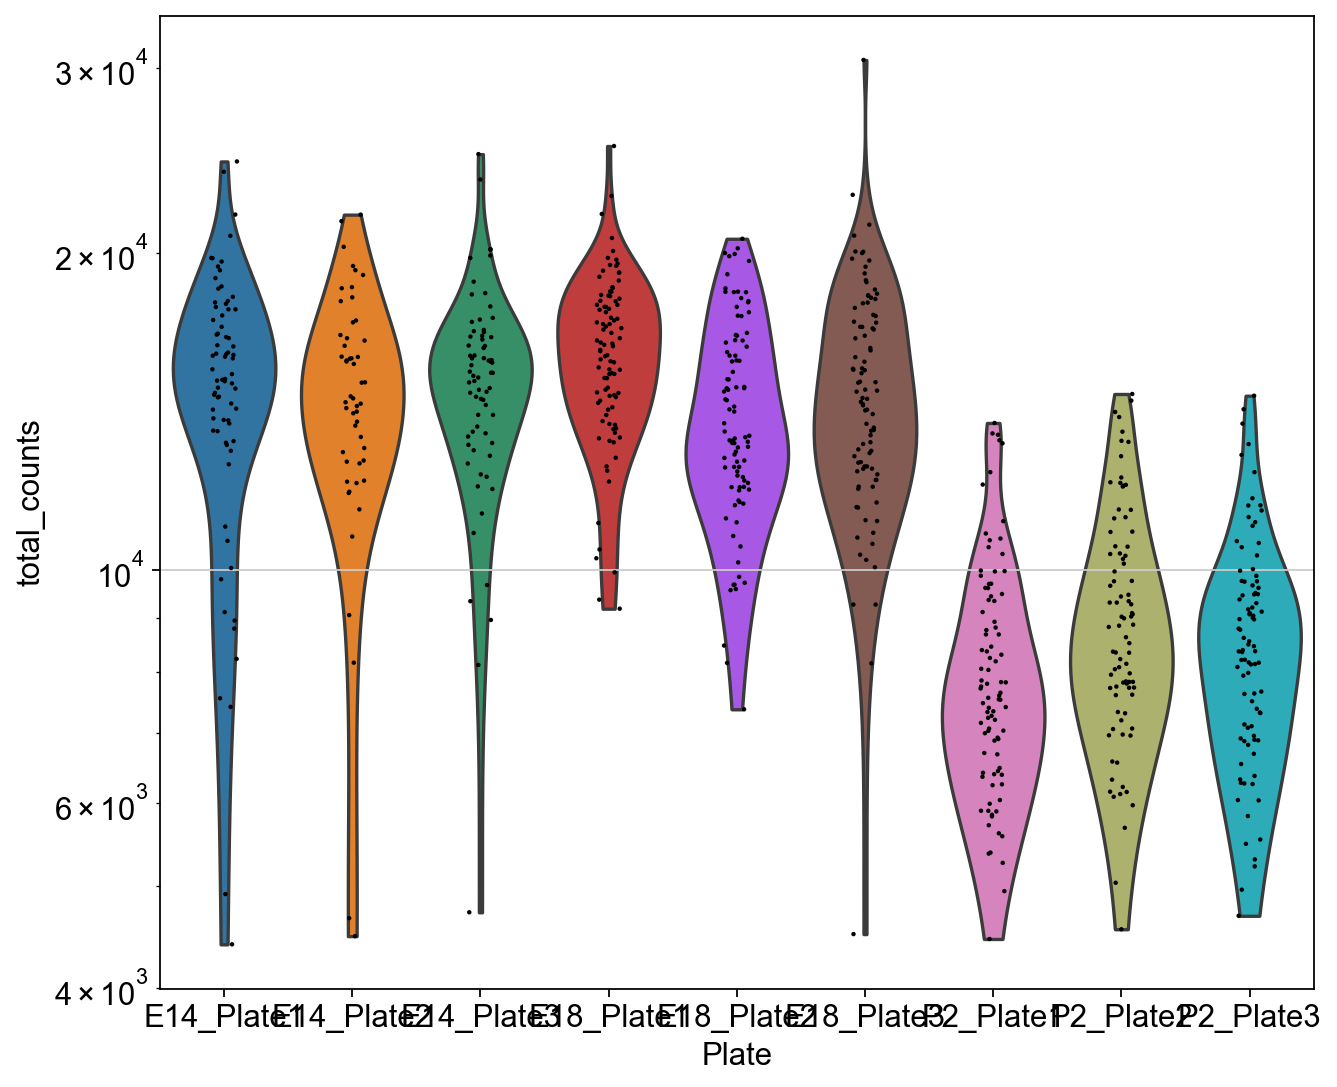

In [6]:
# Quality control - plot QC metrics
#Sample quality plots
t1 = sc.pl.violin(adata, 'total_counts', groupby='Plate', size=2, log=True, cut=0)


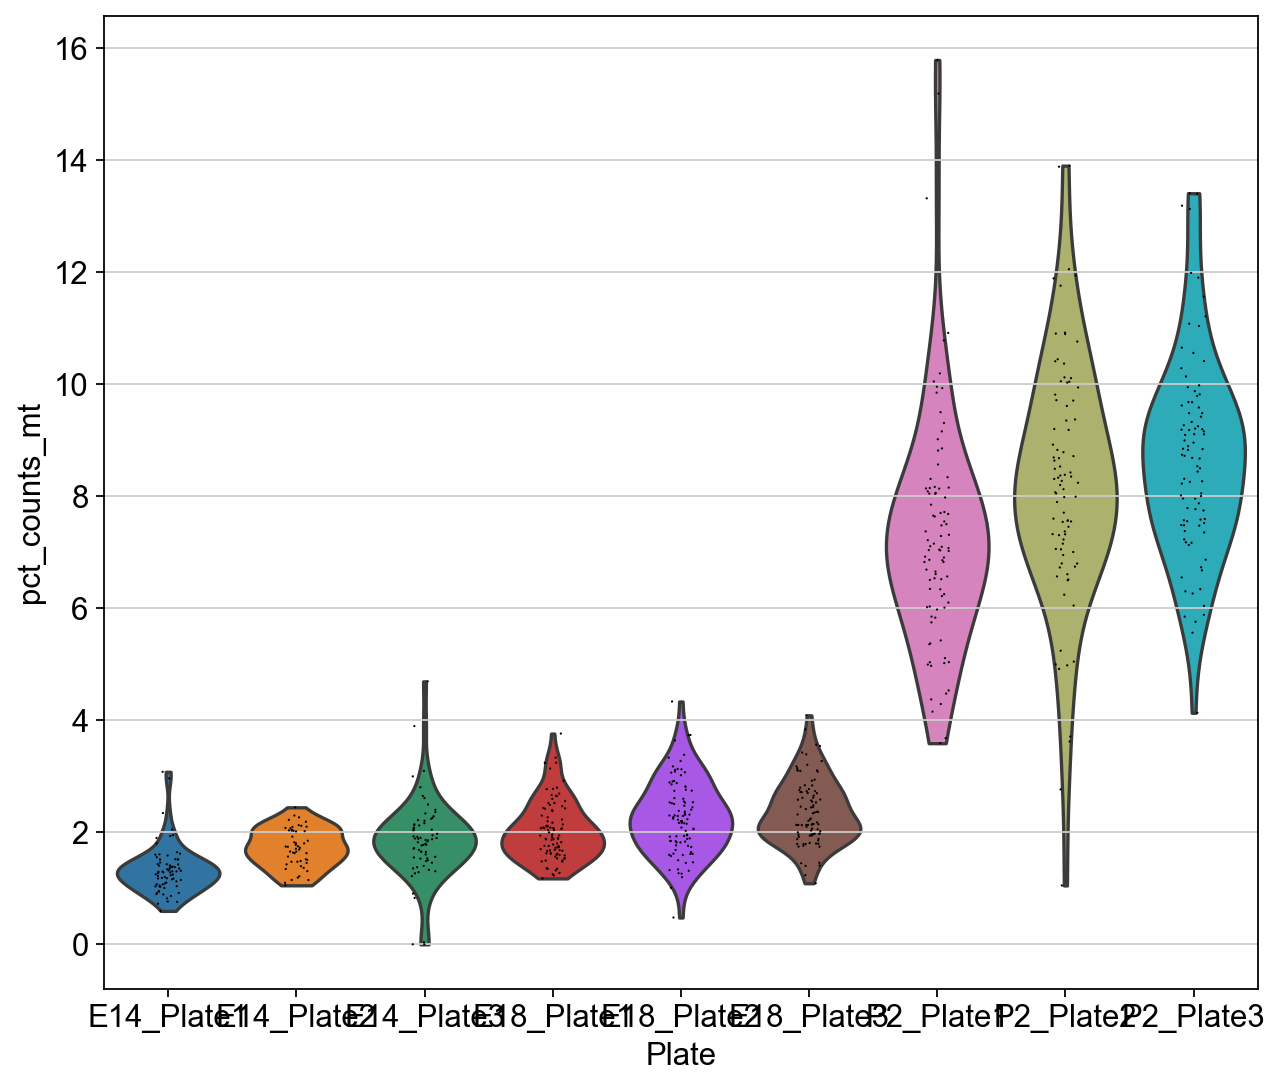

In [7]:
t2 = sc.pl.violin(adata, 'pct_counts_mt', groupby='Plate')


Seems like P2 plate cells are mostly damaged. 